# Supervised Learning with `PyTorch`

<a href="https://colab.research.google.com/drive/1wR5WnJFE9mGov_-yPkLagGXTR41VAGu5" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

[PyTorch](https://pytorch.org/) is a popular open-source machine learning framework developed by Facebook's AI Research team. It is built to provide flexibility and speed to researchers and developers working on deep learning projects.

PyTorch offers an intuitive and Pythonic interface that enables easy construction and training of complex neural networks. PyTorch also offers a rich set of tools and utilities for data preprocessing, model evaluation, and deployment. It has gained significant traction in the deep learning community due to its ease of use, speed, and flexibility.


![torch](https://user-images.githubusercontent.com/42931974/68615320-d6bf3380-04e8-11ea-84f8-dcef049f1ed3.gif)

[Source](https://github.com/AnilNITT/PyTorch-for-beginner).

In this tutorial, we will implement a neural network, not from scratch, but using PyTorch. We will be training our network via `supervised learning`.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html), [TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html), all of which include datasets. For this tutorial, we will be using a TorchVision dataset.

The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html), or just use `dir(datasets)`).

In this tutorial, we use the `Fashion_MNIST dataset`. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform` to modify the samples and labels, respectively.


In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:00<00:00, 105338326.41it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 8981056.48it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 65577598.62it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17427180.78it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Loading the `datasets.FashionMNIST` gives us the same dataset we used in the previous notebook.

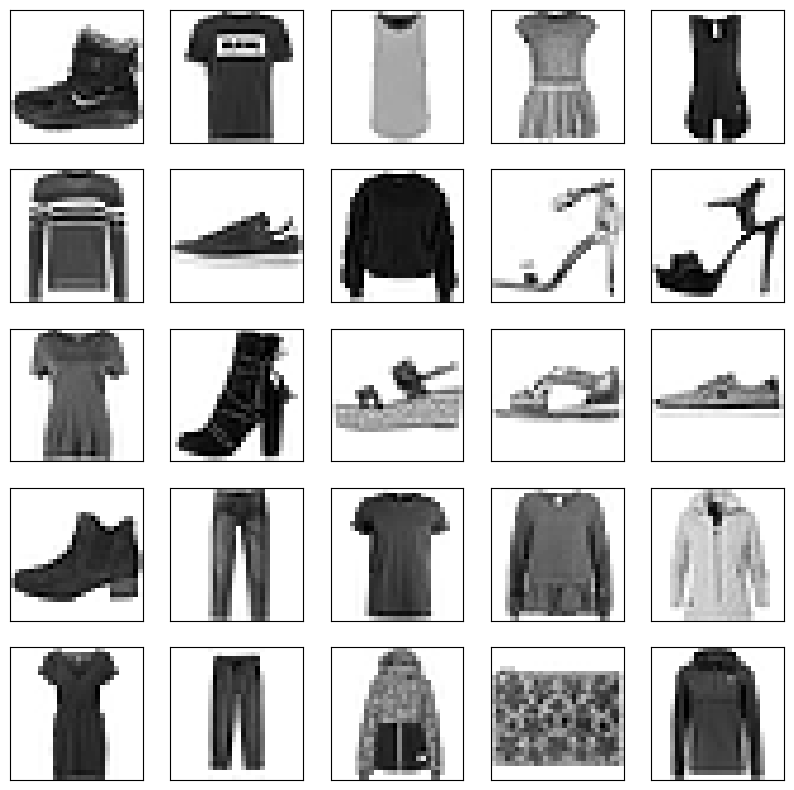

In [ ]:
import torch
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(torch.squeeze(training_data[i][0]), cmap=plt.cm.binary)

plt.show()

PyTorch has its own methods. For example, here, we will pass the `Dataset` as an argument to a `DataLoader`. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e., each element in the `DataLoader` iterable will return a batch of 64 images and labels.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f'Sixe of train_data: {len(train_dataloader.dataset)}')
    print(f'Sixe of test_data: {len(test_dataloader.dataset)}')
    print(f'Shape of X [Batch, Channels, Height, Width]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Sixe of train_data: 60000
Sixe of test_data: 10000
Shape of X [Batch, Channels, Height, Width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Neural networks in PyTorch are usually built using classes, inducing the user to OOP (`object oriented programming`).

To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the network layers in the `__init__` function and specify how data will pass through the network in the `forward` function. We move it to the GPU if available to accelerate operations in the neural network.

In [ ]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    """
    A feedforward neural network that consists of
    four fully connected layers with ReLU activation
    functions, and a softmax activation function at
    the output layer. The network takes input of
    shape (batch_size, 1, 28, 28) and produces
    output of shape (batch_size, 10), where each
    element in the output represents the predicted
    probability of the input image belonging to
    one of the 10 classes (0-9).

    Attributes:
    -----------
    flatten : nn.Flatten
        A module that flattens the input to a 1D tensor.
    linear_relu_stack : nn.Sequential
        A sequence of fully connected layers with ReLU activation
        functions.

    Methods:
    --------
    forward(x)
        Performs forward propagation on the input tensor x
        and returns the output logits.
    """
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)



Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


As before, we need a `loss function` and an `optimizer` to train a model. In a single training loop, the model makes predictions on the training dataset (fed to it in batches) and backpropagates the prediction error to adjust the model’s parameters.

We will also create a function to evaluate our model after training.

In [ ]:
# our loss function
loss_fn = nn.CrossEntropyLoss()

# the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    # for every batch in the dataloader
    for batch, (X, y) in enumerate(dataloader):

        # move the batch to the device (CPU or GPU)
        X, y = X.to(device), y.to(device)

        # make a prediction
        pred = model(X)

        # use the loss function to calculate the loss
        loss = loss_fn(pred, y)

        # reset the gradients of the optimizer to zero
        optimizer.zero_grad()

        # backpropagate the loss
        loss.backward()

        # perform an update to the parameters
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'>> Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate the accuracy of the predictions in a batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n>> Accuracy: {(100*correct):>0.1f}%\n>> Avg loss: {test_loss:>8f} \n")


The training process is conducted over several iterations (_epochs_). As usual, the model learns new parameters during each epoch to make better predictions.


In [ ]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)


Epoch 1
--------------------------------
>> Loss: 2.300707  [    0/60000]
>> Loss: 2.302816  [ 6400/60000]
>> Loss: 2.301031  [12800/60000]
>> Loss: 2.301285  [19200/60000]
>> Loss: 2.294868  [25600/60000]
>> Loss: 2.283386  [32000/60000]
>> Loss: 2.287358  [38400/60000]
>> Loss: 2.279450  [44800/60000]
>> Loss: 2.281208  [51200/60000]
>> Loss: 2.267759  [57600/60000]
Test Error: 
>> Accuracy: 20.8%
>> Avg loss: 2.277023 

Epoch 2
--------------------------------
>> Loss: 2.275969  [    0/60000]
>> Loss: 2.279758  [ 6400/60000]
>> Loss: 2.271825  [12800/60000]
>> Loss: 2.275166  [19200/60000]
>> Loss: 2.268454  [25600/60000]
>> Loss: 2.251772  [32000/60000]
>> Loss: 2.260715  [38400/60000]
>> Loss: 2.246759  [44800/60000]
>> Loss: 2.249928  [51200/60000]
>> Loss: 2.232908  [57600/60000]
Test Error: 
>> Accuracy: 28.7%
>> Avg loss: 2.241486 

Epoch 3
--------------------------------
>> Loss: 2.243896  [    0/60000]
>> Loss: 2.246746  [ 6400/60000]
>> Loss: 2.228395  [12800/60000]
>> Los

Like in Keras, we can easily save and load our model.

A common way to save a model is to serialize the internal state dictionary (containing the model parameters). The process for loading a model includes re-creating the model structure and loading the state dictionary into it.


In [ ]:
torch.save(model.state_dict(), 'fashion_model.pt')
model = NeuralNetwork()
model.load_state_dict(torch.load('fashion_model.pt'))


<All keys matched successfully>

This model can now be used to make predictions. The trained model outputs raw prediction `logits`. To convert them to a probability distribution, we can use (just like before) a `softmax function`.


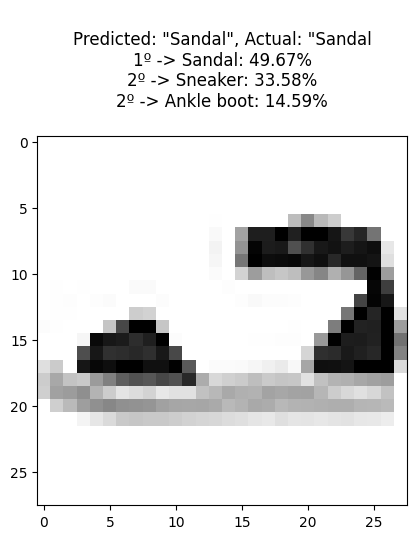

In [ ]:
import torch.nn.functional as nnf
import numpy as np

model.eval()

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

sample = np.random.randint(0, 9999)
x, y = test_data[sample][0], test_data[sample][1]

with torch.no_grad():
    pred = model(x)

prob = nnf.softmax(pred, dim=1)

top_p, top_class = prob.topk(3, dim=1)

predicted, actual = classes[top_class[0][0]], classes[y]

plt.imshow(torch.squeeze(test_data[sample][0]), cmap=plt.cm.binary)
plt.title(f'''
Predicted: "{predicted}", Actual: "{actual}
1º -> {classes[top_class[0][0]]}: {(top_p[0][0]*100):>0.2f}%
2º -> {classes[top_class[0][1]]}: {(top_p[0][1]*100):>0.2f}%
2º -> {classes[top_class[0][2]]}: {(top_p[0][2]*100):>0.2f}%
''')
plt.show()


Pytorch gives the user greater visibility to much of what the Keras/Tensorflow library hides. However, in the end, both frameworks make sure the job gets done, and which one you choose to use (_you will probably use both if you want to practice ML_) is a matter of taste and preference! 🙃

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
